<a href="https://colab.research.google.com/github/TEA-HWAN-JEONG/ds-project/blob/main/ai12_project1_%EC%A0%95%ED%83%9C%ED%99%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Code States_Section1_Project1_AI12_정태환**
목표 : 다음 분기에 어떤 게임을 설계해야 할까
1.   지역별로 선호하는 게임 장르 : 지역별로 출고량이 높은 게임의 장르 확인, 지역별로 장르별 평균 출고량 파악

     **=> 지역별 선호 장르 파악**
2.   지역별 선호하는 플랫폼 : 지역별 출고량이 높은 게임의 플랫폼 확인, 지역별로 플랫폼별 평균 출고량 파악

     **=> 지역별 선호 플랫폼 파악**
3.   연도별 게임 트렌드 : 연도별로 출고량이 높은 게임의 장르 확인, 연도별로 장르별 평균 출고량 파악, 연도별 출고된 게임의 장르 빈도수

     **=> 전체 시장 최신 장르 트렌드 파악**
4.   연도별 플랫폼 트렌드 : 연도별로 출고량이 높은 게임의 플랫폼 확인, 연도별로 플랫폼별 평균 출고량 파악, 연도별 출고된 게임의 플랫폼 빈도수

     **=> 전체 시장 최신 플랫폼 트렌드 파악**
5.   지역별 연도별 게임 트렌드 : 지역별로 연도별 출고량이 높은 게임의 장르 확인, 지역별로 연도별 장르별 평균 출고량 파악

     **=> 지역별 최신 트렌드 파악** 
6.   정리 및 최종 결정 : 지역 선정 - 장르 선정 - 플랫폼 선정 - 고출고량 게임들을 참고하여 게임 설계

     **=> 최종 결정**
## **1. 데이터 전처리**
> **데이터 불러오기 및 결측값 제거**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vgames2.csv')
df = df.iloc[:, 1:]

#결측값 처리
print('결측값 확인 :\n', df.isnull().sum())
df.dropna(inplace= True)
print('\n결측값 제거 :\n', df.isnull().sum())
df.head()

결측값 확인 :
 Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

결측값 제거 :
 Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


> **Year 칼럼 데이터 정제**

Year칼럼에서 4자리 수가 아닌 3, 11, 97 등의 한~두자리 숫자들의 경우 다음과 같이 해석함.

*   22이하의 값 => 2022년 이전의 2000년대 값, 예를 들면 3은 2003년으로 해석
*   23이상의 값 => 1900년대 값, 예를 들면 97은 1997년으로 해석

해석 근거 : 플랫폼을 통한 게임이 상용화된 시점이 1900년대 말과 현재까지이므로 그 범위내에서 정해진다고 가정하면, 한~두자리 숫자들은 앞부분 20, 19를 생략했을 가능성이 크다고 생각함.

In [ ]:
print('통일 전 :\n', df.iloc[72:85,1:4])
def re_year(arg):
  if arg >= 100:
    return arg
  else:
    if arg <= 22:
      return 2000+arg
    else:
      return 1900+arg

df['Year'] = df['Year'].apply(re_year)
print('\n통일 후 :\n', df.iloc[72:85,1:4])

통일 전 :
    Platform    Year         Genre
74       PC     9.0      Strategy
75      PS3  2010.0        Sports
76      NES  1985.0      Platform
77       PS  2000.0      Platform
78       DS  2007.0        Puzzle
79      Wii  2008.0        Racing
80      GBA  2005.0        Action
81       PS    97.0        Action
82       PS  1997.0      Strategy
83       GC  2003.0      Platform
84      N64  2000.0      Fighting
85      PS2  2003.0        Action
86     SNES  1995.0  Role-Playing

통일 후 :
    Platform    Year         Genre
74       PC  2009.0      Strategy
75      PS3  2010.0        Sports
76      NES  1985.0      Platform
77       PS  2000.0      Platform
78       DS  2007.0        Puzzle
79      Wii  2008.0        Racing
80      GBA  2005.0        Action
81       PS  1997.0        Action
82       PS  1997.0      Strategy
83       GC  2003.0      Platform
84      N64  2000.0      Fighting
85      PS2  2003.0        Action
86     SNES  1995.0  Role-Playing


> **지역별 출고량 단위 통일**

각 지역별 출고량 칼럼에서 단위가 M,K 등 통일되지 않음을 확인!

그래서 Kaggle에서 참고한 데이터 설명을 참고하여, 단위 표시가 없는 숫자들과 M단위로 표현된 숫자들이 비슷한 것에 착안하여 단위 표시가 없는 숫자들의 단위를 M으로 정하고 전체 데이터를 정수형식으로 만지고자 단위 표시만 제외한 상태로 모두 K단위로 변환

*   기존 M단위로 표시된 숫자 => M단위 표시 제거, K단위로 맞추기 위해 1000곱하기
*   기존 K단위로 표시된 숫자 => K단위 표시 제거
*   기존 단위표시가 없는 숫자 => K단위로 맞추기 위해 1000곱하기

In [ ]:
print('통일 전 :\n', df.iloc[10:15,5:])
def to_M(arg):
  arg = str(arg)
  if 'M' in arg:
    arg = float(arg.replace('M', ''))*1000
  elif 'K' in arg:
    arg = float(arg.replace('K', ''))
  else:
    arg = float(arg)*1000
  return arg

df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']] = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].applymap(to_M)
print('\n통일 후 :\n', df.iloc[10:15,5:])

통일 전 :
    NA_Sales EU_Sales JP_Sales Other_Sales
10     480K    0.33M       0K        0.06
11     0.14     0.05        0           0
12        0     0.02        0           0
13     0.02        0        0           0
14        0        0     0.02           0

통일 후 :
     NA_Sales  EU_Sales  JP_Sales  Other_Sales
10     480.0     330.0       0.0         60.0
11     140.0      50.0       0.0          0.0
12       0.0      20.0       0.0          0.0
13      20.0       0.0       0.0          0.0
14       0.0       0.0      20.0          0.0


> **통합 출고량 칼럼 추가**

'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'

각 지역별 출고량을 모두 더하여 게임당 전체 Total 출고량을 'Total_Sales'라는 칼럼에 Manipulation

In [ ]:
df['Total_Sales'] = df['NA_Sales']+df['EU_Sales']+df['JP_Sales']+df['Other_Sales']
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,40.0,0.0,0.0,0.0,40.0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,170.0,0.0,0.0,10.0,180.0
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,20.0,0.0,20.0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,40.0,0.0,0.0,0.0,40.0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,120.0,90.0,0.0,40.0,250.0


> **그 외**

Publisher 칼럼값에서 발견되는 Unknown의 경우, Publisher 칼럼이 출고량에 큰 영향을 미치지는 않는다는 판단하에 그대로 두기로 하였다.

## **2. EDA**
> **출고량 시각화**

간단하게 박스 플롯과 히스토그램으로 시각화

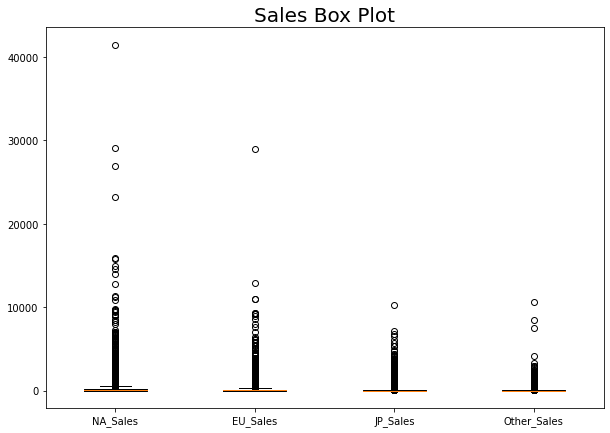

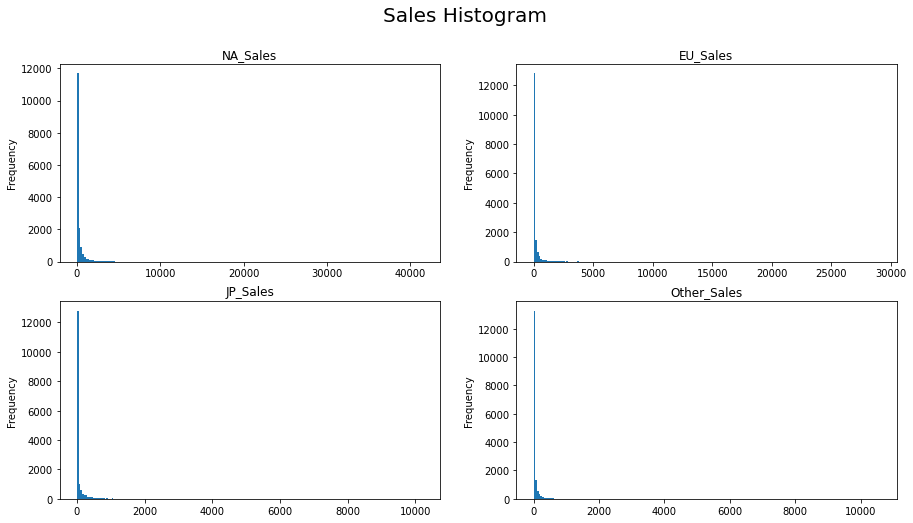

In [ ]:
#box plot 시각화
plt.figure(figsize= (10, 7))
plt.boxplot([df['NA_Sales'], df['EU_Sales'], df['JP_Sales'], df['Other_Sales']])
plt.title('Sales Box Plot', fontsize= 20)
plt.xticks([1, 2, 3, 4], labels= ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])

#histogram 시각화
fig, axes= plt.subplots(2, 2, figsize= (15, 8))
fig.suptitle('Sales Histogram', fontsize= 20)
axes[0][0].hist(df['NA_Sales'], bins= 200)
axes[0][0].set_title('NA_Sales')
axes[0][0].set_ylabel('Frequency')
axes[0][1].hist(df['EU_Sales'], bins= 200)
axes[0][1].set_title('EU_Sales')
axes[0][1].set_ylabel('Frequency')
axes[1][0].hist(df['JP_Sales'], bins= 200)
axes[1][0].set_title('JP_Sales')
axes[1][0].set_ylabel('Frequency')
axes[1][1].hist(df['Other_Sales'], bins= 200)
axes[1][1].set_title('Other_Sales')
axes[1][1].set_ylabel('Frequency')
plt.show()

박스 플롯과 히스토그램을 통해 대부분의 출고량 분포가 0~10000k 사이에 분포하는 것을 관찰할 수 있었다.

NA_Sales, EU_Sales 칼럼의 경우, 출고량이 10000k를 훨씬 넘는 이상치들이 다수 존재하였다. 이를 이상치로 두고 제거하기에는 매우 인기있었던 게임일 수도 있기에 추출하여 데이터를 직접 확인해보았다.

In [ ]:
#NA지역에서 출고량이 10000k가 넘는 데이터들
df_NA = df[df['NA_Sales']>10000]
df_NA

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
1203,Tetris,GB,1989.0,Puzzle,Nintendo,23200.0,2260.0,4220.0,580.0,30260.0
2908,Wii Sports,Wii,2006.0,Sports,Nintendo,41490.0,29020.0,3770.0,8460.0,82740.0
3014,Wii Play,Wii,2006.0,Misc,Nintendo,14030.0,9200.0,2930.0,2850.0,29010.0
3352,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15750.0,11010.0,3280.0,2960.0,33000.0
4199,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29080.0,3580.0,6810.0,770.0,40240.0
4343,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,14970.0,4940.0,240.0,1670.0,21820.0
6937,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11380.0,9230.0,6500.0,2900.0,30010.0
7829,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11270.0,8890.0,10220.0,1000.0,31380.0
9491,Super Mario Land,GB,1989.0,Platform,Nintendo,10830.0,2710.0,4180.0,420.0,18140.0
10488,Duck Hunt,NES,1984.0,Shooter,Nintendo,26930.0,630.0,280.0,470.0,28310.0


닌텐도 will의 경우 총 출고량이 80000k를 넘어설 정도로 많은 출고량을 기록했다. 실제로 출시 당시, 한국에서도 그 열기를 느꼈을 정도로 많은 인기가 있었다고 생각해서 이 데이터의 아웃라이어는 매우 큰 의미를 가진다고 판단하여 제거하지 않았다.

In [ ]:
#EU지역에서 출고량이 10000k가 넘는 데이터들
df_EU = df[df['EU_Sales']>10000]
df_EU

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2908,Wii Sports,Wii,2006.0,Sports,Nintendo,41490.0,29020.0,3770.0,8460.0,82740.0
3352,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15750.0,11010.0,3280.0,2960.0,33000.0
11137,Nintendogs,DS,2005.0,Simulation,Nintendo,9070.0,11000.0,1930.0,2750.0,24750.0
12579,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15850.0,12880.0,3790.0,3310.0,35830.0


In [ ]:
#JP지역에서 출고량이 10000k가 넘는 데이터들
df_JP = df[df['JP_Sales']>10000]
df_JP

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
7829,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11270.0,8890.0,10220.0,1000.0,31380.0


In [ ]:
#Other지역에서 출고량이 10000k가 넘는 데이터들
df_O = df[df['Other_Sales']>10000]
df_O

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
14669,Grand Theft Auto: San Andreas,PS2,2004.0,Action,Take-Two Interactive,9430.0,400.0,410.0,10570.0,20810.0


In [ ]:
#전체 지역에서 출고량이 30000k가 넘는 데이터들
df[df['Total_Sales']>30000]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
1203,Tetris,GB,1989.0,Puzzle,Nintendo,23200.0,2260.0,4220.0,580.0,30260.0
2908,Wii Sports,Wii,2006.0,Sports,Nintendo,41490.0,29020.0,3770.0,8460.0,82740.0
3352,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15750.0,11010.0,3280.0,2960.0,33000.0
4199,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29080.0,3580.0,6810.0,770.0,40240.0
6937,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11380.0,9230.0,6500.0,2900.0,30010.0
7829,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11270.0,8890.0,10220.0,1000.0,31380.0
12579,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15850.0,12880.0,3790.0,3310.0,35830.0


PS2의 GTA를 제외하고는 고출고량을 기록한 게임들은 모두 닌텐도에서 제작하였다. 플랫폼 또한 모두 닌텐도 자체 플랫폼이었다.

## **3. 분석**
> **지역별 분석**

지역별로 선호하는 게임 장르 : 지역별로 출고량이 높은 게임의 장르 확인, 지역별로 장르별 평균 출고량 파악

In [ ]:
#지역별로 출고량이 높은 게임의 장르 확인

#NA지역
print('NA :\n', df_NA.groupby('Genre')['Name'].count())
print('=> 고출고량의 게임들 중에서는 Platform이 가장 많음\n')

#EU지역
print('EU :\n', df_EU.groupby('Genre')['Name'].count())
print('=> 고출고량의 게임들 중에서는 Sports가 조금 많음\n')

#JP지역
print('JP :\n', df_JP.groupby('Genre')['Name'].count())
print('=> 고출고량의 게임들 중에서는 Role-Playing이 유일\n')

#Other지역
print('Other :\n', df_O.groupby('Genre')['Name'].count())
print('=> 고출고량의 게임들 중에서는 Action이 유일')

NA :
 Genre
Misc            2
Platform        5
Puzzle          1
Racing          1
Role-Playing    1
Shooter         1
Sports          2
Name: Name, dtype: int64
=> 고출고량의 게임들 중에서는 Platform이 가장 많음

EU :
 Genre
Racing        1
Simulation    1
Sports        2
Name: Name, dtype: int64
=> 고출고량의 게임들 중에서는 Sports가 조금 많음

JP :
 Genre
Role-Playing    1
Name: Name, dtype: int64
=> 고출고량의 게임들 중에서는 Role-Playing이 유일

Other :
 Genre
Action    1
Name: Name, dtype: int64
=> 고출고량의 게임들 중에서는 Action이 유일


NA_mean :
 Genre
Action          265.046296
Adventure        80.276025
Fighting        263.892216
Misc            234.818560
Platform        510.171821
Puzzle          214.805654
Racing          290.976210
Role-Playing    217.583618
Shooter         448.812500
Simulation      214.456265
Sports          290.239234
Strategy        101.390135
Name: NA_Sales, dtype: float64

평균 출고량이 높은 장르는 Platform, Shooter 이다.

NA_median :
 Genre
Action          100.0
Adventure         0.0
Fighting         80.0
Misc             80.0
Platform        140.0
Puzzle           50.0
Racing          100.0
Role-Playing     40.0
Shooter         120.0
Simulation       70.0
Sports          110.0
Strategy          0.0
Name: NA_Sales, dtype: float64

출고량 중앙값이 높은 장르도 마찬가지로 Platform, Shooter 이다.



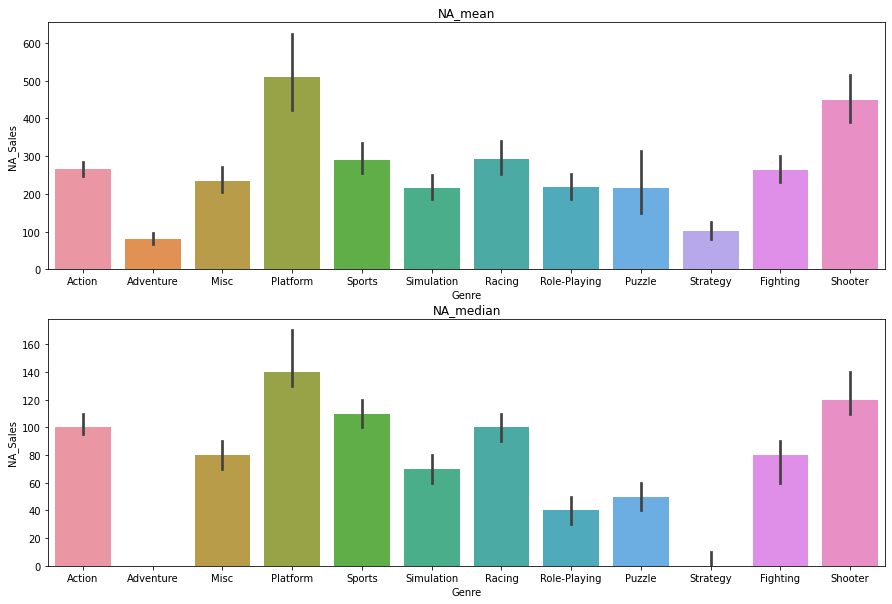

In [ ]:
#지역별로 장르별 평균 출고량 파악
#데이터에 극단치가 많으므로 중앙값으로도 확인
#NA지역
na_mean = df.groupby('Genre')['NA_Sales'].mean()
na_median = df.groupby('Genre')['NA_Sales'].median()
print('NA_mean :\n', na_mean)
print('\n평균 출고량이 높은 장르는 Platform, Shooter 이다.\n')
print('NA_median :\n', na_median)
print('\n출고량 중앙값이 높은 장르도 마찬가지로 Platform, Shooter 이다.\n')

fig, axes = plt.subplots(2, 1, figsize= (15,10))
sns.barplot(data= df, x= 'Genre', y= 'NA_Sales', ax= axes[0])
axes[0].set_title('NA_mean')
sns.barplot(data=df, x= 'Genre', y= 'NA_Sales', estimator=np.median, ax= axes[1])
axes[1].set_title('NA_median')
plt.show()

EU_mean :
 Genre
Action          158.530864
Adventure        50.205047
Fighting        119.640719
Misc            123.825104
Platform        229.816724
Puzzle           89.169611
Racing          192.797375
Role-Playing    124.976109
Shooter         242.367188
Simulation      133.557920
Sports          161.361462
Strategy         66.995516
Name: EU_Sales, dtype: float64

평균 출고량이 높은 장르는 Platform, Shooter 이다.

EU_median :
 Genre
Action          30.0
Adventure        0.0
Fighting        30.0
Misc            10.0
Platform        50.0
Puzzle          10.0
Racing          40.0
Role-Playing    10.0
Shooter         50.0
Simulation      10.0
Sports          20.0
Strategy        10.0
Name: EU_Sales, dtype: float64

출고량 중앙값이 높은 장르도 마찬가지로 Platform, Shooter 이다.



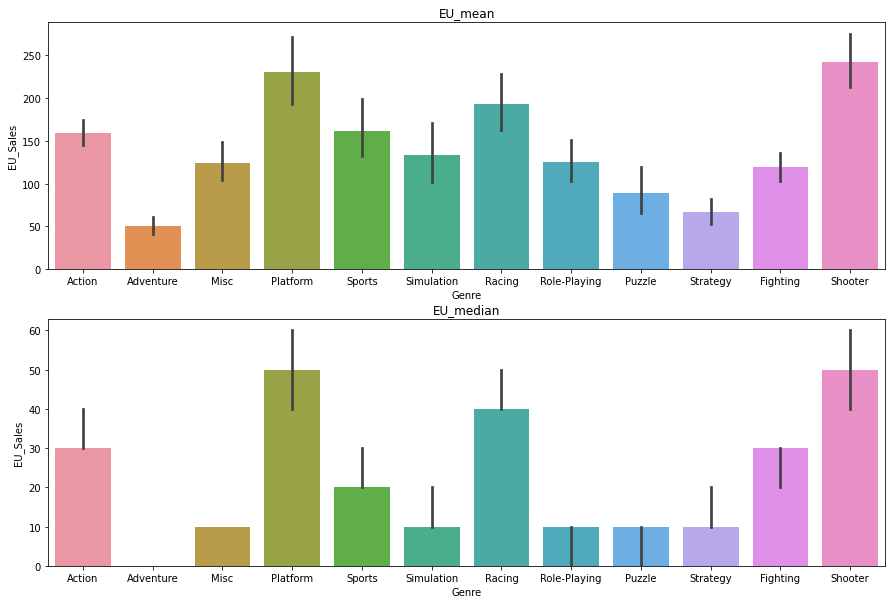

In [ ]:
#EU지역
eu_mean = df.groupby('Genre')['EU_Sales'].mean()
eu_median = df.groupby('Genre')['EU_Sales'].median()
print('EU_mean :\n', eu_mean)
print('\n평균 출고량이 높은 장르는 Platform, Shooter 이다.\n')
print('EU_median :\n', eu_median)
print('\n출고량 중앙값이 높은 장르도 마찬가지로 Platform, Shooter 이다.\n')

fig, axes = plt.subplots(2, 1, figsize= (15,10))
sns.barplot(data= df, x= 'Genre', y= 'EU_Sales', ax= axes[0])
axes[0].set_title('EU_mean')
sns.barplot(data=df, x= 'Genre', y= 'EU_Sales', estimator=np.median, ax= axes[1])
axes[1].set_title('EU_median')
plt.show()

JP_mean :
 Genre
Action           48.333333
Adventure        40.906940
Fighting        104.359281
Misc             61.975015
Platform        149.518900
Puzzle           99.363958
Racing           46.201805
Role-Playing    234.081911
Shooter          29.828125
Simulation       75.106383
Sports           58.616790
Strategy         73.393124
Name: JP_Sales, dtype: float64

평균 출고량이 높은 장르는 Platform, Role-Playing 이다.

JP_median :
 Genre
Action           0.0
Adventure       10.0
Fighting        20.0
Misc             0.0
Platform         0.0
Puzzle           0.0
Racing           0.0
Role-Playing    50.0
Shooter          0.0
Simulation       0.0
Sports           0.0
Strategy         0.0
Name: JP_Sales, dtype: float64

출고량 중앙값이 높은 장르는 Role-Playing 뿐이다.



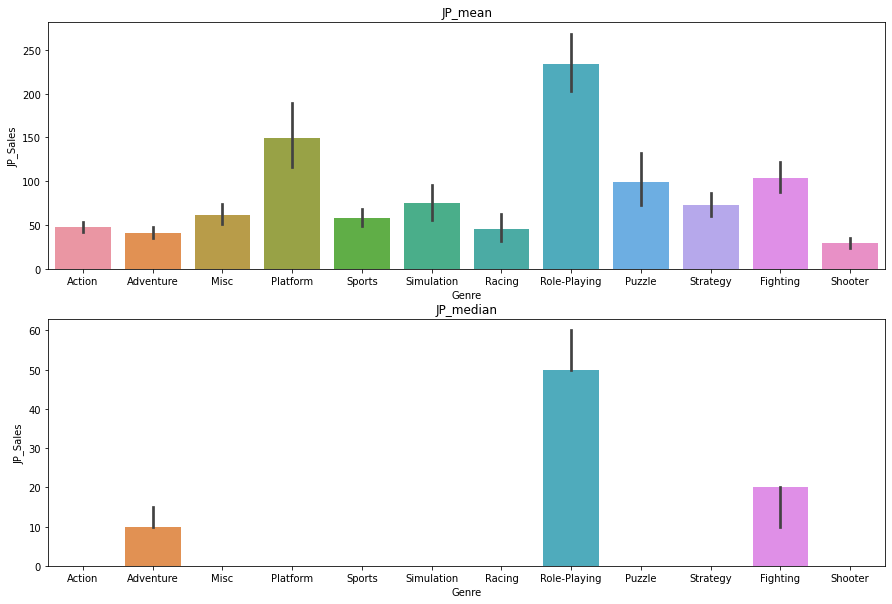

In [ ]:
#JP지역
jp_mean = df.groupby('Genre')['JP_Sales'].mean()
jp_median = df.groupby('Genre')['JP_Sales'].median()
print('JP_mean :\n', jp_mean)
print('\n평균 출고량이 높은 장르는 Platform, Role-Playing 이다.\n')
print('JP_median :\n', jp_median)
print('\n출고량 중앙값이 높은 장르는 Role-Playing 뿐이다.\n')

fig, axes = plt.subplots(2, 1, figsize= (15,10))
sns.barplot(data= df, x= 'Genre', y= 'JP_Sales', ax= axes[0])
axes[0].set_title('JP_mean')
sns.barplot(data=df, x= 'Genre', y= 'JP_Sales', estimator=np.median, ax= axes[1])
axes[1].set_title('JP_median')
plt.show()

Other_mean :
 Genre
Action          56.787037
Adventure       13.170347
Fighting        43.293413
Misc            43.212374
Platform        58.934708
Puzzle          21.978799
Racing          62.764561
Role-Playing    38.723549
Shooter         79.578125
Simulation      37.021277
Sports          57.568508
Strategy        16.786248
Name: Other_Sales, dtype: float64

평균 출고량이 높은 장르는 Shooter 이다.

Other_median :
 Genre
Action          10.0
Adventure        0.0
Fighting        10.0
Misc            10.0
Platform        10.0
Puzzle          10.0
Racing          10.0
Role-Playing    10.0
Shooter         20.0
Simulation      10.0
Sports          10.0
Strategy         0.0
Name: Other_Sales, dtype: float64

출고량 중앙값이 높은 장르도 마찬가지로 Shooter 이다.



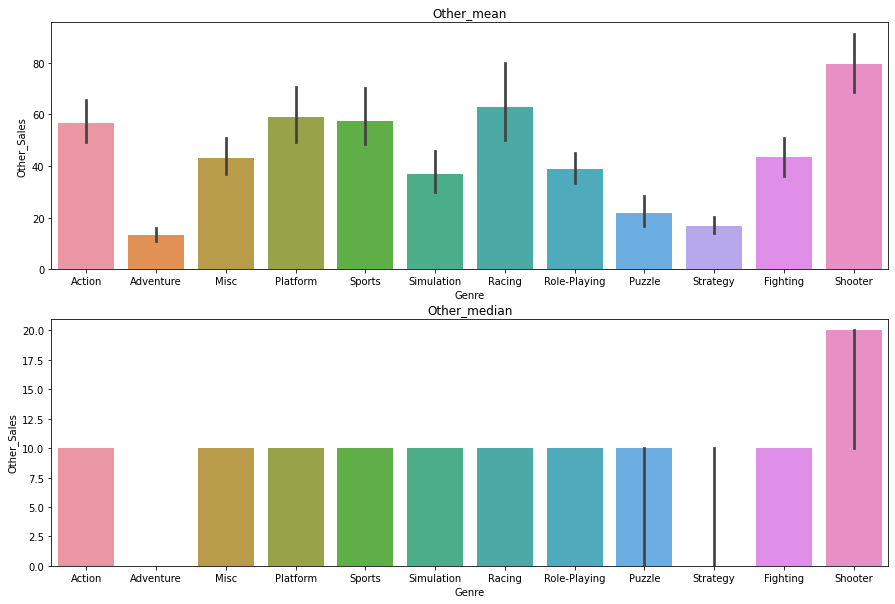

In [ ]:
#Other지역
o_mean = df.groupby('Genre')['Other_Sales'].mean()
o_median = df.groupby('Genre')['Other_Sales'].median()
print('Other_mean :\n', o_mean)
print('\n평균 출고량이 높은 장르는 Shooter 이다.\n')
print('Other_median :\n', o_median)
print('\n출고량 중앙값이 높은 장르도 마찬가지로 Shooter 이다.\n')

fig, axes = plt.subplots(2, 1, figsize= (15,10))
sns.barplot(data= df, x= 'Genre', y= 'Other_Sales', ax= axes[0])
axes[0].set_title('Other_mean')
sns.barplot(data=df, x= 'Genre', y= 'Other_Sales', estimator=np.median, ax= axes[1])
axes[1].set_title('Other_median')
plt.show()

지역별 선호하는 플랫폼 : 지역별 출고량이 높은 게임의 플랫폼 확인, 지역별로 플랫폼별 평균 출고량 파악

In [ ]:
#지역별로 출고량이 높은 게임의 플랫폼 확인

#NA지역
print('NA :\n', df_NA.groupby('Platform')['Name'].count())
print('=> 고출고량의 게임들 중에서는 Will이 가장 많음\n')

#EU지역
print('EU :\n', df_EU.groupby('Platform')['Name'].count())
print('=> 고출고량의 게임들 중에서는 Will이 가장 많음\n')

#JP지역
print('JP :\n', df_JP.groupby('Platform')['Name'].count())
print('=> 고출고량의 게임들 중에서는 Game Boy가 유일\n')

#Other지역
print('Other :\n', df_O.groupby('Platform')['Name'].count())
print('=> 고출고량의 게임들 중에서는 PS2가 유일')

NA :
 Platform
DS      1
GB      3
NES     2
SNES    1
Wii     5
X360    1
Name: Name, dtype: int64
=> 고출고량의 게임들 중에서는 Will이 가장 많음

EU :
 Platform
DS     1
Wii    3
Name: Name, dtype: int64
=> 고출고량의 게임들 중에서는 Will이 가장 많음

JP :
 Platform
GB    1
Name: Name, dtype: int64
=> 고출고량의 게임들 중에서는 Game Boy가 유일

Other :
 Platform
PS2    1
Name: Name, dtype: int64
=> 고출고량의 게임들 중에서는 PS2가 유일


NA_mean :
 Platform
2600     698.434783
3DO        0.000000
3DS      146.305221
DC       104.423077
DS       182.383639
GB      1171.546392
GBA      227.372449
GC       243.512015
GEN      713.703704
GG         0.000000
N64      441.980831
NES     1285.102041
NG         0.000000
PC        98.427807
PCFX       0.000000
PS       281.679325
PS2      268.052805
PS3      298.691301
PS4      285.970149
PSP       89.270746
PSV       39.290954
SAT        4.161850
SCD      166.666667
SNES     256.192469
TG16       0.000000
WS         0.000000
Wii      385.591900
WiiU     267.972028
X360     482.355808
XB       224.330413
XOne     392.405660
Name: NA_Sales, dtype: float64

평균 출고량이 높은 플랫폼은 GB, NES 이다.



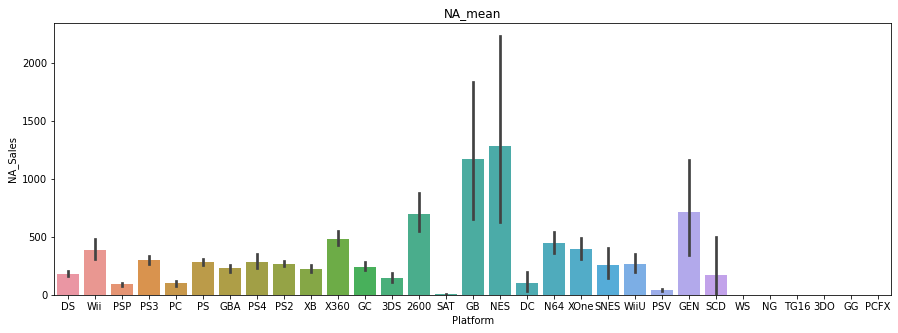

In [ ]:
#지역별로 플랫폼별 평균 출고량 파악
#NA지역
na_mean = df.groupby('Platform')['NA_Sales'].mean()
print('NA_mean :\n', na_mean)
print('\n평균 출고량이 높은 플랫폼은 GB, NES 이다.\n')
plt.figure(figsize= (15, 5))
sns.barplot(data= df, x= 'Platform', y= 'NA_Sales')
plt.title('NA_mean')
plt.show()

EU_mean :
 Platform
2600     42.000000
3DO       0.000000
3DS     108.915663
DC       32.500000
DS       91.231782
GB      489.793814
GBA      92.385204
GC       70.739372
GEN     204.444444
GG        0.000000
N64     129.936102
NES     215.816327
NG        0.000000
PC      146.000000
PCFX      0.000000
PS      178.691983
PS2     156.544083
PS3     261.516551
PS4     366.985075
PSP      56.286672
PSV      39.779951
SAT       3.121387
SCD      60.000000
SNES     79.665272
TG16      0.000000
WS        0.000000
Wii     203.099688
WiiU    169.440559
X360    225.751422
XB       73.053817
XOne    215.235849
Name: EU_Sales, dtype: float64

평균 출고량이 높은 플랫폼은 GB, PS4 이다.



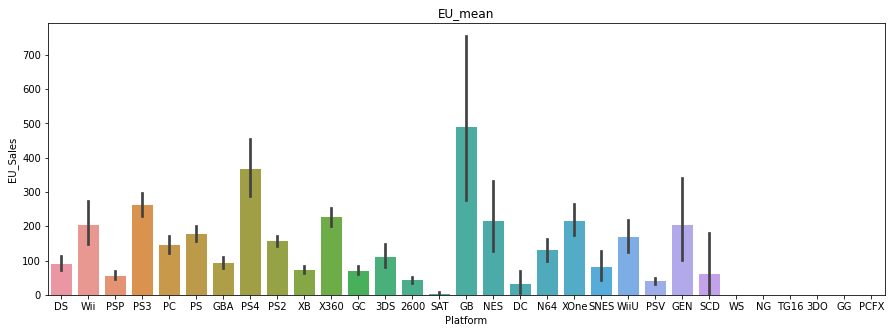

In [ ]:
#EU지역
eu_mean = df.groupby('Platform')['EU_Sales'].mean()
print('EU_mean :\n', eu_mean)
print('\n평균 출고량이 높은 플랫폼은 GB, PS4 이다.\n')
plt.figure(figsize= (15, 5))
sns.barplot(data= df, x= 'Platform', y= 'EU_Sales')
plt.title('EU_mean')
plt.show()

JP_mean :
 Platform
2600       0.000000
3DO       33.333333
3DS      186.666667
DC       164.615385
DS        82.261401
GB       877.525773
GBA       59.387755
GC        38.632163
GEN       98.888889
GG        40.000000
N64      106.932907
NES     1006.632653
NG       120.000000
PC         0.181818
PCFX      30.000000
PS       117.375527
PS2       63.224894
PS3       60.477290
PS4       41.910448
PSP       63.470243
PSV       50.880196
SAT      186.473988
SCD       75.000000
SNES     487.656904
TG16      80.000000
WS       236.666667
Wii       51.238318
WiiU      89.440559
X360       9.983753
XB         1.727159
XOne       1.603774
Name: JP_Sales, dtype: float64

평균 출고량이 높은 플랫폼은 GB, NES 이다.



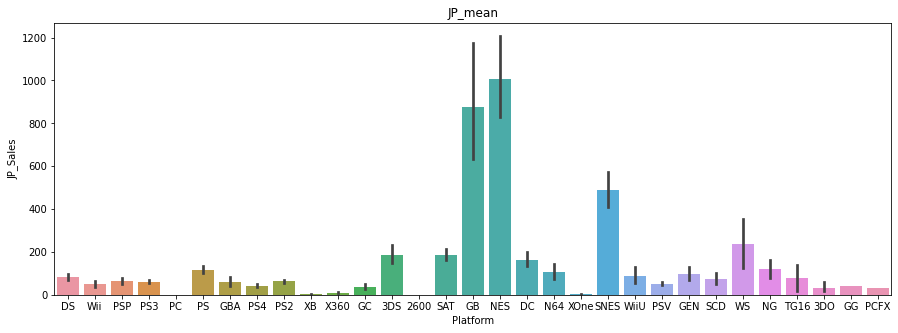

In [ ]:
#JP지역
jp_mean = df.groupby('Platform')['JP_Sales'].mean()
print('JP_mean :\n', jp_mean)
print('\n평균 출고량이 높은 플랫폼은 GB, NES 이다.\n')
plt.figure(figsize= (15, 5))
sns.barplot(data= df, x= 'Platform', y= 'JP_Sales')
plt.title('JP_mean')
plt.show()

Other_mean :
 Platform
2600      7.217391
3DO       0.000000
3DS      23.614458
DC        5.192308
DS       28.321580
GB       84.123711
GBA       9.579082
GC        9.445471
GEN      32.962963
GG        0.000000
N64      13.674121
NES      54.183673
NG        0.000000
PC       25.925134
PCFX      0.000000
PS       34.202532
PS2      88.528996
PS3     108.137028
PS4     128.358209
PSP      34.761106
PSV      20.562347
SAT       0.404624
SCD       8.333333
SNES     13.472803
TG16      0.000000
WS        0.000000
Wii      61.121495
WiiU     45.104895
X360     68.740861
XB       10.400501
XOne     56.226415
Name: Other_Sales, dtype: float64

평균 출고량이 높은 플랫폼은 PS3, PS4 이다.



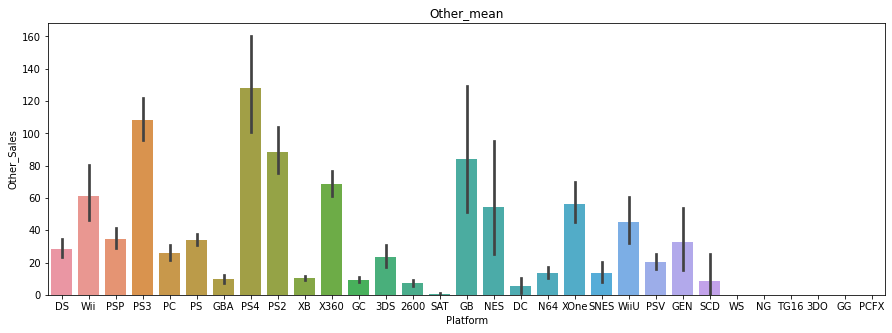

In [ ]:
#Other지역
o_mean = df.groupby('Platform')['Other_Sales'].mean()
print('Other_mean :\n', o_mean)
print('\n평균 출고량이 높은 플랫폼은 PS3, PS4 이다.\n')
plt.figure(figsize= (15, 5))
sns.barplot(data= df, x= 'Platform', y= 'Other_Sales')
plt.title('Other_mean')
plt.show()

> **연도별 트렌드**

연도별 게임 트렌드 : 연도별로 출고량이 높은 게임의 장르 확인, 연도별로 장르별 평균 출고량 파악, 연도별 출고된 게임의 장르 빈도수

In [ ]:
#연도별로 출고량이 높은 게임의 장르 확인

#연도별로 가장 높은 전체 출고량 테이블 형성
df_year = df.groupby('Year')['Total_Sales'].max()
df2 = df[(df['Year']==df_year.index[0]) & (df['Total_Sales']==df_year.values[0])]
df2 = df2.iloc[0:1,:]
for i in range(1, len(df_year)):
  temp = df[(df['Year']==df_year.index[i]) & (df['Total_Sales']==df_year.values[i])]
  if len(temp) > 1:
    temp = temp.iloc[0:1,:]
  df2 = df2.append(temp)
df2[['Year', 'Total_Sales', 'Name', 'Genre']]

,Year,Total_Sales,Name,Genre
5723,1980.0,4310.0,Asteroids,Shooter
15885,1981.0,4500.0,Pitfall!,Platform
5820,1982.0,7810.0,Pac-Man,Puzzle
466,1983.0,3200.0,Baseball,Sports
10488,1984.0,28310.0,Duck Hunt,Shooter
4199,1985.0,40240.0,Super Mario Bros.,Platform
10791,1986.0,6500.0,The Legend of Zelda,Action
9997,1987.0,4380.0,Zelda II: The Adventure of Link,Adventure
14856,1988.0,17280.0,Super Mario Bros. 3,Platform
1203,1989.0,30260.0,Tetris,Puzzle


가장 최근에 출고된 게임의 장르는 Simulation이지만 전체 출고량이 너무 낮아서 출고량이 10000K을 넘기는 2010~2015년의 게임 장르를 참고하여야 최신 트렌드를 파악할 수 있을 것 같다.

*   1980년대 : Super Mario Bros의 Platform, Tetris의 Puzzle 장르가 높은 출고량을 기록하며 트렌드를 이끌었다.
*   1990년대 : Pokemon Red/Blue, Pokemon Gold/Silver가 출시되면서 Role-Playing 장르가 인기를 끌었다.
*   2000년대 : Will Sports가 압도적인 출고량을 기록하면서 Sports 장르가 인기가 많았고 그 외에도 Will 플랫폼을 기반으로 게임들이 대량으로 출고되면서 다시 한번 닌텐도의 전성시대가 도래했다.
*   2010년대 : PS 플랫폼 기반의 Call of Duty, GTA시리즈가 큰 인기를 얻어 높은 출고량을 기록하였다. 그러면서 Shooting, Action 장르가 트렌드가 되었다.
*   2020년대 : 2010년대부터 PC, 모바일 기반의 게임들이 큰 인기를 누리게 되면서 자연스럽게 플랫폼 기반의 게임들은 출고량이 줄어들게 되었다.





변환 전 :
 Year    Genre       
1980.0  Action           340.0
        Fighting         770.0
        Misc             675.0
        Shooter         3535.0
1981.0  Action           591.6
                         ...  
2016.0  Sports           385.0
        Strategy          52.0
2017.0  Action            10.0
        Role-Playing      20.0
2020.0  Simulation       290.0
Name: Total_Sales, Length: 388, dtype: float64 

최종 테이블 : 
        Year         Genre   Total_Sales
3    1980.0       Shooter   3535.000000
5    1981.0      Platform   2306.666667
14   1982.0        Puzzle   3346.666667
24   1983.0        Sports   3200.000000
30   1984.0       Shooter  10366.666667
34   1985.0      Platform  10792.500000
42   1986.0  Role-Playing   2520.000000
46   1987.0     Adventure   4380.000000
53   1988.0      Platform   6932.500000
63   1989.0        Puzzle   7550.000000
68   1990.0      Platform   7660.000000
74   1991.0        Action   1352.000000
92   1992.0        Racing   4525.000000
102  1993.

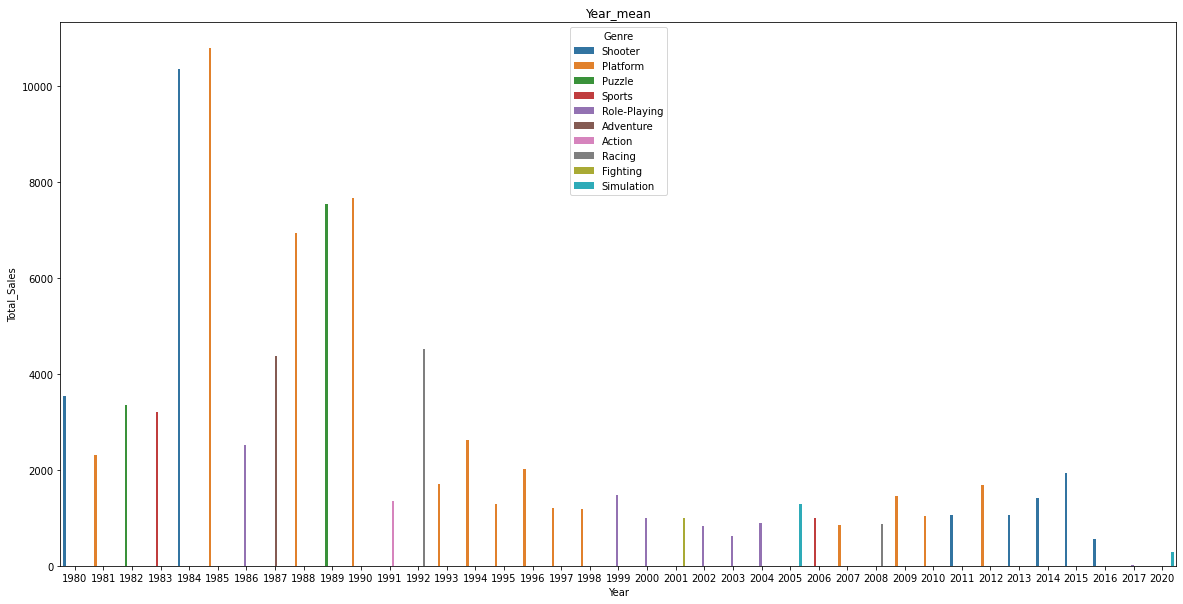

In [ ]:
#연도별로 장르별 평균 출고량 파악

#연도별 장르별 평균 출고량
df_year2 = df.groupby(['Year', 'Genre'])['Total_Sales'].mean()
print('변환 전 :\n', df_year2, '\n')
df_year2 = df_year2.reset_index()

#연도별 장르별 평균 출고량들 중 최고값만 추출하여 테이블 생성
df3 = df_year2[(df_year2['Year'] == df_year.index[0]) & (df_year2['Total_Sales'] == df_year2[df_year2['Year'] == df_year.index[0]]['Total_Sales'].max())]
df3 = df3.iloc[0:1,:]
for i in range(1, len(df_year)):
   temp = df_year2[(df_year2['Year'] == df_year.index[i]) & (df_year2['Total_Sales'] == df_year2[df_year2['Year'] == df_year.index[i]]['Total_Sales'].max())]
   if len(temp) > 1:
    temp = temp.iloc[0:1,:]
   df3 = df3.append(temp)
print('최종 테이블 : \n', df3)

#그래프를 깔끔하게 만들기 위해 연도를 float에서 int 형식으로 형변환
def toInt(arg):
  return int(arg)
df3['Year'] = df3['Year'].apply(toInt)

#barplot으로 시각화
plt.figure(figsize= (20, 10))
sns.barplot(data= df3, x= 'Year', y= 'Total_Sales', hue= 'Genre')
plt.title('Year_mean')
plt.xticks(fontsize= 10)
plt.show()

2006년 Will Sports의 압도적 출고량에 비해 2006년 Sports장르 출고량 평균은 다소 낮게 나왔다.

변환 전 :
 Year    Genre       
1980.0  Action           1
        Fighting         1
        Misc             4
        Shooter          2
1981.0  Action          25
                        ..
2016.0  Sports          38
        Strategy        10
2017.0  Action           1
        Role-Playing     2
2020.0  Simulation       1
Name: Name, Length: 388, dtype: int64

최종 테이블 : 
        Year         Genre  Name
2    1980.0          Misc     4
4    1981.0        Action    25
11   1982.0        Action    18
18   1983.0        Action     7
28   1984.0        Puzzle     3
34   1985.0      Platform     4
39   1986.0        Action     6
51   1987.0        Sports     4
53   1988.0      Platform     4
63   1989.0        Puzzle     5
67   1990.0        Action     3
84   1991.0        Sports     7
88   1992.0      Fighting     7
100  1993.0      Fighting    11
112  1994.0      Fighting    22
124  1995.0      Fighting    29
144  1996.0        Sports    52
156  1997.0        Sports    46
168  1998.0     

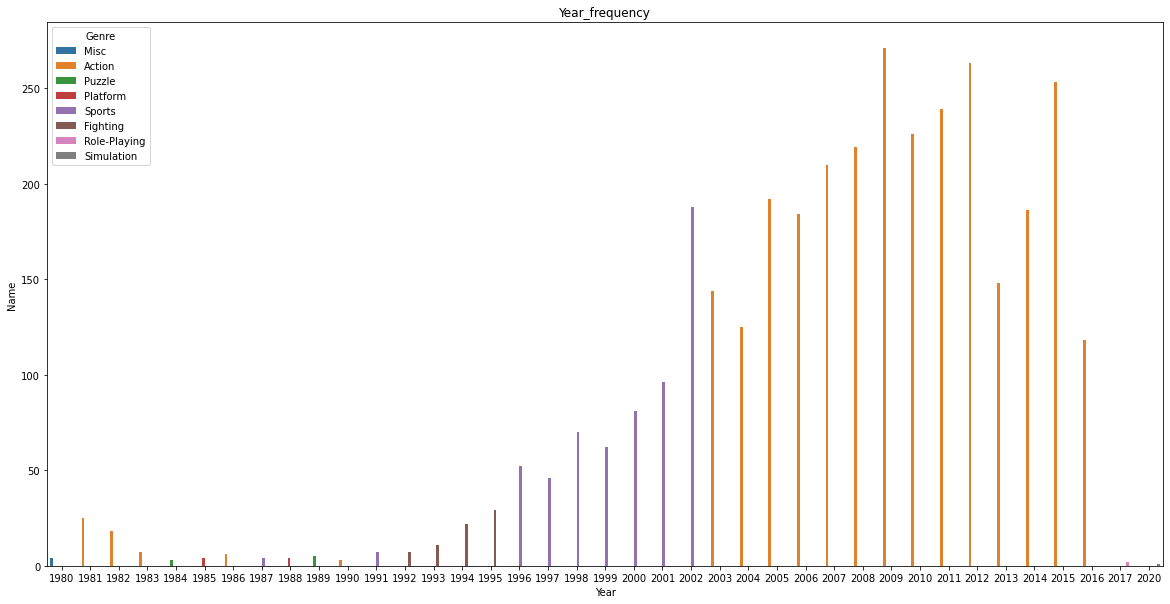

In [ ]:
#연도별 출고된 게임의 장르 빈도수

#연도별 장르별 빈도수
df_year3 = df.groupby(['Year', 'Genre'])['Name'].count()
print('변환 전 :\n', df_year3)
df_year3 = df_year3.reset_index()

#연도별 장르별 빈도수 중 최고값만 추출하여 테이블 생성
df4 = df_year3[(df_year3['Year'] == df_year.index[0]) & (df_year3['Name'] == df_year3[df_year3['Year'] == df_year.index[0]]['Name'].max())]
df4 = df4.iloc[0:1,:]
for i in range(1, len(df_year)):
   temp = df_year3[(df_year3['Year'] == df_year.index[i]) & (df_year3['Name'] == df_year3[df_year3['Year'] == df_year.index[i]]['Name'].max())]
   if len(temp) > 1:
    temp = temp.iloc[0:1,:]
   df4 = df4.append(temp)
print('\n최종 테이블 : \n', df4)

#그래프를 깔끔하게 만들기 위해 연도를 float에서 int 형식으로 형변환
df4['Year'] = df4['Year'].apply(toInt)

#barplot으로 시각화
plt.figure(figsize= (20, 10))
sns.barplot(data= df4, x= 'Year', y= 'Name', hue= 'Genre')
plt.title('Year_frequency')
plt.xticks(fontsize= 10)
plt.show()

2000년도를 넘어서면서 Action 장르의 게임들이 압도적으로 많이 출시되었음을 알 수 있다.


연도별 플랫폼 트렌드 : 연도별로 출고량이 높은 게임의 플랫폼 확인, 연도별로 플랫폼별 평균 출고량 파악, 연도별 출고된 게임의 플랫폼 빈도수

In [ ]:
#연도별로 출고량이 높은 게임의 플랫폼 확인

#연도별로 가장 높은 전체 출고량 테이블 형성
df_year = df.groupby('Year')['Total_Sales'].max()
df2 = df[(df['Year']==df_year.index[0]) & (df['Total_Sales']==df_year.values[0])]
df2 = df2.iloc[0:1,:]
for i in range(1, len(df_year)):
  temp = df[(df['Year']==df_year.index[i]) & (df['Total_Sales']==df_year.values[i])]
  if len(temp) > 1:
    temp = temp.iloc[0:1,:]
  df2 = df2.append(temp)
df2[['Year', 'Total_Sales', 'Name', 'Platform', 'Publisher']]

,Year,Total_Sales,Name,Platform,Publisher
5723,1980.0,4310.0,Asteroids,2600,Atari
15885,1981.0,4500.0,Pitfall!,2600,Activision
5820,1982.0,7810.0,Pac-Man,2600,Atari
466,1983.0,3200.0,Baseball,NES,Nintendo
10488,1984.0,28310.0,Duck Hunt,NES,Nintendo
4199,1985.0,40240.0,Super Mario Bros.,NES,Nintendo
10791,1986.0,6500.0,The Legend of Zelda,NES,Nintendo
9997,1987.0,4380.0,Zelda II: The Adventure of Link,NES,Nintendo
14856,1988.0,17280.0,Super Mario Bros. 3,NES,Nintendo
1203,1989.0,30260.0,Tetris,GB,Nintendo


가장 최근에 출고된 게임의 플랫폼은 닌텐도 DS이지만 전체 출고량이 너무 낮아서 출고량이 10000K을 넘기는 2010~2015년의 게임 장르를 참고하여야 최신 트렌드를 파악할 수 있을 것 같다.

*   1980년대 : 닌텐도 NES플랫폼이 인기를 끌었다. 말쯤에는 GB플랫폼의 Tetris가 출시되면서 패미컴, 게임보이의 콘솔 게임기를 통해 전세계를 제패했다.
*   1990년대 : Pokemon, 슈퍼마리오 시리즈를 SNES, GB플랫폼을 통해 출시하면서 계속해서 높은 출고량을 점유하였다.
*   2000년대 : PS2의 등장으로 잠시 선두자리를 뺏겼지만 DS와 Will을 통해 다시 한번 닌텐도의 전성시대가 도래했다.
*   2010년대 : PS3, PS4 플랫폼의 등장으로 소니의 전성기가 찾아왔다.
*   2020년대 : 2010년대부터 PC, 모바일기반의 게임들이 큰 인기를 누리게 되면서 자연스럽게 플랫폼 기반의 게임들은 출고량이 줄어들게 되었다.

변환 전 :
 Year    Platform
1980.0  2600        1360.000000
1981.0  2600         775.652174
1982.0  2600         802.222222
1983.0  2600         530.909091
        NES         1826.666667
                       ...     
2016.0  X360         103.750000
        XOne         229.259259
2017.0  PS4           30.000000
        PSV           10.000000
2020.0  DS           290.000000
Name: Total_Sales, Length: 241, dtype: float64 

최종 테이블 : 
        Year Platform  Total_Sales
0    1980.0     2600  1360.000000
1    1981.0     2600   775.652174
2    1982.0     2600   802.222222
4    1983.0      NES  1826.666667
6    1984.0      NES  3852.307692
9    1985.0      NES  4858.181818
12   1986.0      NES  1916.315789
14   1987.0      NES  1976.000000
17   1988.0      NES  4091.818182
20   1989.0       GB  6497.000000
25   1990.0     SNES  6537.500000
27   1991.0      GEN  4330.000000
30   1992.0       GB  3641.428571
39   1993.0      SCD  1500.000000
42   1994.0       GB  4060.000000
54   1995.0       P

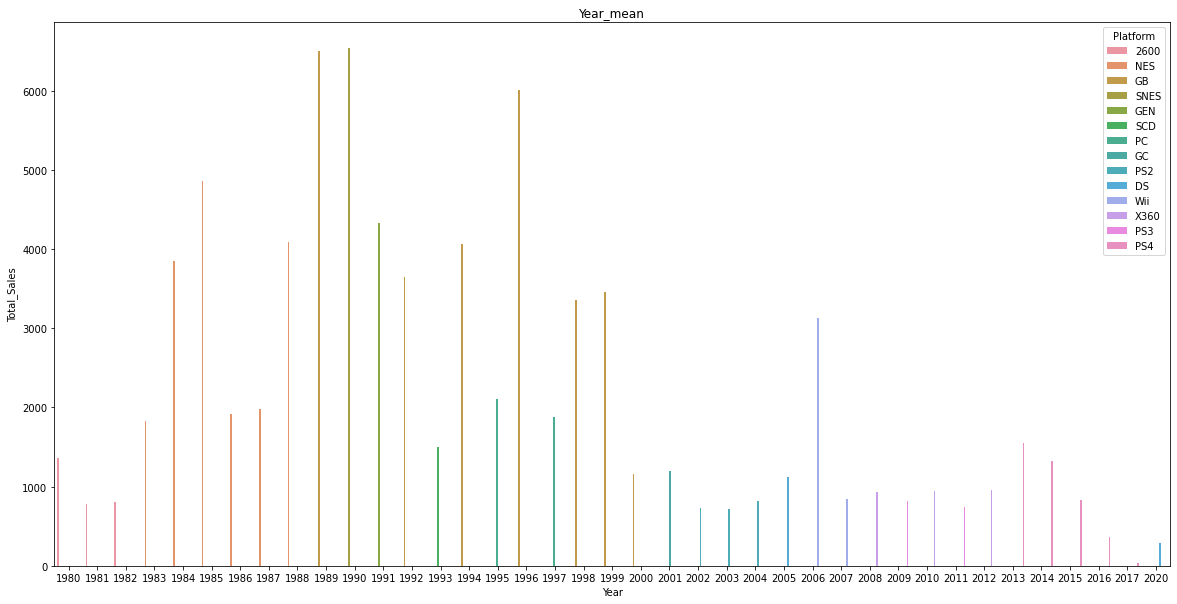

In [ ]:
#연도별로 플랫폼별 평균 출고량 파악

#연도별 플랫폼별 평균 출고량
df_year2 = df.groupby(['Year', 'Platform'])['Total_Sales'].mean()
print('변환 전 :\n', df_year2, '\n')
df_year2 = df_year2.reset_index()

#연도별 플랫폼별 평균 출고량들 중 최고값만 추출하여 테이블 생성
df3 = df_year2[(df_year2['Year'] == df_year.index[0]) & (df_year2['Total_Sales'] == df_year2[df_year2['Year'] == df_year.index[0]]['Total_Sales'].max())]
df3 = df3.iloc[0:1,:]
for i in range(1, len(df_year)):
   temp = df_year2[(df_year2['Year'] == df_year.index[i]) & (df_year2['Total_Sales'] == df_year2[df_year2['Year'] == df_year.index[i]]['Total_Sales'].max())]
   if len(temp) > 1:
    temp = temp.iloc[0:1,:]
   df3 = df3.append(temp)
print('최종 테이블 : \n', df3)

#그래프를 깔끔하게 만들기 위해 연도를 float에서 int 형식으로 형변환
df3['Year'] = df3['Year'].apply(toInt)

#barplot으로 시각화
plt.figure(figsize= (20, 10))
sns.barplot(data= df3, x= 'Year', y= 'Total_Sales', hue= 'Platform')
plt.title('Year_mean')
plt.xticks(fontsize= 10)
plt.show()

2006년 Will Sports의 압도적 출고량에 비해 2006년 Will플랫폼 출고량 평균은 다소 낮게 나왔다.

변환 전 :
 Year    Platform
1980.0  2600         8
1981.0  2600        46
1982.0  2600        36
1983.0  2600        11
        NES          6
                    ..
2016.0  X360         8
        XOne        54
2017.0  PS4          1
        PSV          2
2020.0  DS           1
Name: Name, Length: 241, dtype: int64

최종 테이블 : 
        Year Platform  Name
0    1980.0     2600     8
1    1981.0     2600    46
2    1982.0     2600    36
3    1983.0     2600    11
6    1984.0      NES    13
9    1985.0      NES    11
12   1986.0      NES    19
14   1987.0      NES    10
17   1988.0      NES    11
20   1989.0       GB    10
24   1990.0      NES     8
29   1991.0     SNES    24
35   1992.0     SNES    21
40   1993.0     SNES    46
50   1994.0     SNES    53
55   1995.0       PS    99
64   1996.0       PS   163
70   1997.0       PS   188
77   1998.0       PS   248
84   1999.0       PS   198
93   2000.0       PS   159
104  2001.0      PS2   184
113  2002.0      PS2   280
119  2003.0      PS2   2

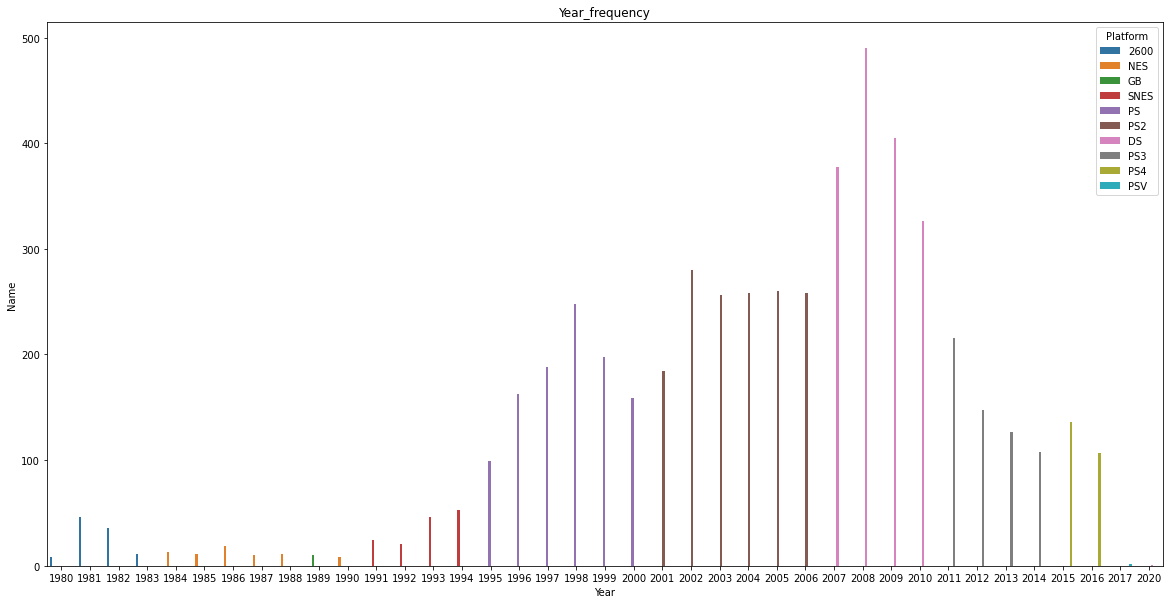

In [ ]:
#연도별 출고된 게임의 플랫폼 빈도수

#연도별 플랫폼별 빈도수
df_year3 = df.groupby(['Year', 'Platform'])['Name'].count()
print('변환 전 :\n', df_year3)
df_year3 = df_year3.reset_index()

#연도별 플랫폼별 빈도수 중 최고값만 추출하여 테이블 생성
df4 = df_year3[(df_year3['Year'] == df_year.index[0]) & (df_year3['Name'] == df_year3[df_year3['Year'] == df_year.index[0]]['Name'].max())]
df4 = df4.iloc[0:1,:]
for i in range(1, len(df_year)):
   temp = df_year3[(df_year3['Year'] == df_year.index[i]) & (df_year3['Name'] == df_year3[df_year3['Year'] == df_year.index[i]]['Name'].max())]
   if len(temp) > 1:
    temp = temp.iloc[0:1,:]
   df4 = df4.append(temp)
print('\n최종 테이블 : \n', df4)

#그래프를 깔끔하게 만들기 위해 연도를 float에서 int 형식으로 형변환
df4['Year'] = df4['Year'].apply(toInt)

#barplot으로 시각화
plt.figure(figsize= (20, 10))
sns.barplot(data= df4, x= 'Year', y= 'Name', hue= 'Platform')
plt.title('Year_frequency')
plt.xticks(fontsize= 10)
plt.show()

확실히 2000년대를 기준으로 NES, SNES, GB, PS => PS2, PS3, PS4, DS, Will로 게임기 플랫폼의 변천사를 눈으로 확인할 수 있었다. 2020년대로 들어서면서부터 출고 빈도가 현저하게 줄어듬도 알 수 있다.

> **지역별 최신 트렌드**

지역별 연도별 게임 트렌드 : 지역별로 연도별 출고량이 높은 게임의 장르&플랫폼 확인

In [ ]:
#지역별로 연도별 출고량이 높은 게임의 장르&플랫폼 확인

#NA지역
#연도별로 가장 높은 NA지역 출고량 테이블 형성
df_year = df.groupby('Year')['NA_Sales'].max()
df2 = df[(df['Year']==df_year.index[0]) & (df['NA_Sales']==df_year.values[0])]
df2 = df2.iloc[0:1,:]
for i in range(1, len(df_year)):
  temp = df[(df['Year']==df_year.index[i]) & (df['NA_Sales']==df_year.values[i])]
  if len(temp) > 1:
    temp = temp.iloc[0:1,:]
  df2 = df2.append(temp)
df2[['Year', 'NA_Sales', 'Name', 'Genre', 'Platform', 'Publisher']]

,Year,NA_Sales,Name,Genre,Platform,Publisher
5723,1980.0,4000.0,Asteroids,Shooter,2600,Atari
15885,1981.0,4210.0,Pitfall!,Platform,2600,Activision
5820,1982.0,7280.0,Pac-Man,Puzzle,2600,Atari
16363,1983.0,1220.0,Pitfall II: Lost Caverns,Platform,2600,Activision
10488,1984.0,26930.0,Duck Hunt,Shooter,NES,Nintendo
4199,1985.0,29080.0,Super Mario Bros.,Platform,NES,Nintendo
10791,1986.0,3740.0,The Legend of Zelda,Action,NES,Nintendo
9997,1987.0,2190.0,Zelda II: The Adventure of Link,Adventure,NES,Nintendo
14856,1988.0,9540.0,Super Mario Bros. 3,Platform,NES,Nintendo
1203,1989.0,23200.0,Tetris,Puzzle,GB,Nintendo


In [ ]:
#EU지역
#연도별로 가장 높은 EU지역 출고량 테이블 형성
df_year = df.groupby('Year')['EU_Sales'].max()
df2 = df[(df['Year']==df_year.index[0]) & (df['EU_Sales']==df_year.values[0])]
df2 = df2.iloc[0:1,:]
for i in range(1, len(df_year)):
  temp = df[(df['Year']==df_year.index[i]) & (df['EU_Sales']==df_year.values[i])]
  if len(temp) > 1:
    temp = temp.iloc[0:1,:]
  df2 = df2.append(temp)
df2[['Year', 'EU_Sales', 'Name', 'Genre', 'Platform', 'Publisher']]

,Year,EU_Sales,Name,Genre,Platform,Publisher
5723,1980.0,260.0,Asteroids,Shooter,2600,Atari
15885,1981.0,240.0,Pitfall!,Platform,2600,Activision
5820,1982.0,450.0,Pac-Man,Puzzle,2600,Atari
10081,1983.0,120.0,Mario Bros.,Platform,NES,Nintendo
10488,1984.0,630.0,Duck Hunt,Shooter,NES,Nintendo
4199,1985.0,3580.0,Super Mario Bros.,Platform,NES,Nintendo
10791,1986.0,930.0,The Legend of Zelda,Action,NES,Nintendo
9997,1987.0,500.0,Zelda II: The Adventure of Link,Adventure,NES,Nintendo
14856,1988.0,3440.0,Super Mario Bros. 3,Platform,NES,Nintendo
9491,1989.0,2710.0,Super Mario Land,Platform,GB,Nintendo


In [ ]:
#JP지역
#연도별로 가장 높은 JP지역 출고량 테이블 형성
df_year = df.groupby('Year')['JP_Sales'].max()
df2 = df[(df['Year']==df_year.index[0]) & (df['JP_Sales']==df_year.values[0])]
df2 = df2.iloc[0:1,:]
for i in range(1, len(df_year)):
  temp = df[(df['Year']==df_year.index[i]) & (df['JP_Sales']==df_year.values[i])]
  if len(temp) > 1:
    temp = temp.iloc[0:1,:]
  df2 = df2.append(temp)
df2[['Year', 'JP_Sales', 'Name', 'Genre', 'Platform', 'Publisher']]

,Year,JP_Sales,Name,Genre,Platform,Publisher
5723,1980.0,0.0,Asteroids,Shooter,2600,Atari
664,1981.0,0.0,Smurf: Rescue In Gargamel's Castle,Action,2600,Coleco
210,1982.0,0.0,Mountain King,Action,2600,CBS Electronics
466,1983.0,2350.0,Baseball,Sports,NES,Nintendo
5974,1984.0,2460.0,Golf,Sports,NES,Nintendo
4199,1985.0,6810.0,Super Mario Bros.,Platform,NES,Nintendo
8420,1986.0,2650.0,Super Mario Bros.: The Lost Levels,Platform,NES,Nintendo
4149,1987.0,2410.0,Dragon Warrior II,Role-Playing,NES,Enix Corporation
14856,1988.0,3840.0,Super Mario Bros. 3,Platform,NES,Nintendo
1203,1989.0,4220.0,Tetris,Puzzle,GB,Nintendo


In [ ]:
#Other지역
#연도별로 가장 높은 Other지역 출고량 테이블 형성
df_year = df.groupby('Year')['Other_Sales'].max()
df2 = df[(df['Year']==df_year.index[0]) & (df['Other_Sales']==df_year.values[0])]
df2 = df2.iloc[0:1,:]
for i in range(1, len(df_year)):
  temp = df[(df['Year']==df_year.index[i]) & (df['Other_Sales']==df_year.values[i])]
  if len(temp) > 1:
    temp = temp.iloc[0:1,:]
  df2 = df2.append(temp)
df2[['Year', 'Other_Sales', 'Name', 'Genre', 'Platform', 'Publisher']]

,Year,Other_Sales,Name,Genre,Platform,Publisher
5723,1980.0,50.0,Asteroids,Shooter,2600,Atari
15885,1981.0,50.0,Pitfall!,Platform,2600,Activision
5820,1982.0,80.0,Pac-Man,Puzzle,2600,Atari
466,1983.0,20.0,Baseball,Sports,NES,Nintendo
10488,1984.0,470.0,Duck Hunt,Shooter,NES,Nintendo
4199,1985.0,770.0,Super Mario Bros.,Platform,NES,Nintendo
11610,1986.0,1510.0,Dragon Warrior,Role-Playing,NES,Capcom
9997,1987.0,80.0,Zelda II: The Adventure of Link,Adventure,NES,Nintendo
14856,1988.0,460.0,Super Mario Bros. 3,Platform,NES,Nintendo
1203,1989.0,580.0,Tetris,Puzzle,GB,Nintendo


> **정리**


*   지역별 장르 선호도의 경우, Other 지역을 제외한 나머지 지역에서는 과거 닌텐도의 압도적 활약 덕분에 Platform, Sports, Role-Playing 장르가 가장 인기가 많았었고 플랫폼 또한 닌텐도의 패미컴, 슈퍼패미컴, 게임보이, DS, Will 등 닌텐도 플랫폼이 인기가 많았었다.
*   시대별 트렌드를 반영하게 될 경우, 최근 트렌드 상으로는 jp지역을 제외한 na, eu, other지역에서는 ps3, ps4 플랫폼을 기반으로한 Action, Shooting 장르가 많은 인기를 얻게 되었습니다.
*   이는 각 지역별로 고출고량을 기록한 게임들에서도 나타납니다. 비록 na, eu, jp지역에서는 닌텐도의 게임이 가장 많지만 OTHER지역의 경우는 영향이 적어서 그런지 ps기반 action게임의 인기가 앞선 데이터들과 유사하게 나타났습니다.






## **4. 결론**
> **지역 : NA, EU, Other**

> **장르 : Action**

> **플랫폼 : PS4**